## Signature Methods in Finance
### Part III: Signature and Functional Expansions
#### 3. Signature Functional and Path Reconstruction

- Payoff $g(X_T) = (X_T-X_0)^+$ (ATM vanilla call)

- $p^{BS} = $ Black-Scholes price of a call option with $X_0 = K = 100$, $\sigma_{BS} = 20\%$, $r = 0$. 

- Bachelier embeddings $f_{\sigma}(X_t) = u_{\sigma}(t,x_t)$, where $u_{\sigma}(t,x) = \mathbb{E}^{\mathbb{Q}_\sigma}[g(X_T) \ | \ x_t = x]  \ \to \ g(X_T)$ as $t\to T$. Note that  $ u_{\sigma}(0,x_0) =: u_{\sigma}^0$ is the Bachelier price. 

- First order Taylor ($\lVert \cdot \rVert = $ weighted length)

$$g(X_T) \approx \sum_{\lVert \alpha \rVert \le 1} \lbda_{\alpha}f_{\sigma_{BA}}(X_0) \mathcal{S}_{\alpha}(X_T) =  u_{\sigma_{BA}}^0 + \partial_x u_{\sigma_{BA}}^0 (x_T - x_0) + \partial_t u_{\sigma_{BA}}^0 T +  \partial_{xx} u_{\sigma_{BA}}^0 \frac{(x_T - x_0)^2}{2}$$

As $u_{\sigma_{BA}}$ solves the heat equation $(\partial_t + \frac{\sigma_{BA}^2}{2}\partial_{xx})u = 0$, we can write

$$g(X_T) \approx   u_{\sigma_{BA}}^0 + \partial_x u_{\sigma_{BA}}^0 (x_T - x_0)  +  \partial_{xx} u_{\sigma_{BA}}^0 \frac{(x_T - x_0)^2 - \sigma_{BA}^2 T}{2}$$

[ In the Bachelier($\sigma_{BA}$) model, note that   $\frac{(x_T - x_0)^2 - \sigma_{BA}^2 T}{2} =  \int_0^T\int_0^{t_2} dx_{t_1}dx_{t_2} =  \sigma_{BA}^2 \int_0^T\int_0^{t_2} dw_{t_1}dw_{t_2}$ (2nd order Hermite polynomial) ]

Taking expectation w.r.t. to $\mathbb{Q}$ (Black-Scholes model) gives
$$\text{price}_{BS} \approx  u_{\sigma_{BA}}^0 + \partial_{xx} u_{\sigma_{BA}}^0 \frac{e^{\sigma_{BS}^2T} - 1 - \sigma_{BA}^2 T}{2} \approx \text{price}_{BA} + \frac{1}{2}\Gamma_{\sigma_{BA}}^{BA} T(\sigma_{BS}^2- \sigma_{BA}^2) $$
It is therefore wise to set $\sigma_{BA}$ close to $\sigma_{BS}$. However, there should be a premium under the Black-Scholes model due to the convexity of $e^{\cdot}$, so the "optimal" value for $\sigma_{BA}$ should be larger than $\sigma_{BS}$. A natural choice is $\sigma_{BA} = \sqrt{\mathbb{V}^{\mathbb{Q}}[x_1]} = \sqrt{\frac{e^{\sigma_{BS}^2T} - 1}{T}} > \sigma_{BS}$ , although close to $\sigma_{BS}$ itself.

If $x_0 = K$, it turns out that $$\text{price}_{BS} \le u_{\sigma_{BA}}^0 + \frac{T}{2}\partial_{xx} u_{\sigma_{BA}}^0 (\mathbb{V}^{\mathbb{Q}}[x_1] - \sigma_{BA}^2),$$
where the infimum on the RHS seems to be  attained at  $\sigma_{BA} = \sqrt{\mathbb{V}^{\mathbb{Q}}[x_1]} = \sqrt{\frac{e^{\sigma_{BS}^2T} - 1}{T}}$. 

In [1]:
from quantLib import *
from math import factorial as fact
import matplotlib.pyplot as plt
from cycler import cycler as cyc
cols = ["midnightblue",'indianred','tomato','mediumpurple',"darkred","plum","gold","steelblue"]
colCyc = cyc(color = cols)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "palatino", 
})
import bqplot.pyplot as bqplt
import ipywidgets as wi
from scipy.stats import norm
from bqplot import Axis, LinearScale
import matplotlib.pyplot as plt; plt.style.use('dark_background')
from cycler import cycler as cyc
__ = np.newaxis

In [17]:
# Black-Scholes Parameter (delta is the dividend rate of the underlying. In this class, we always assume that delta = 0)
x0,K,r,delta,sigBS,T = 100,100,0.0,0.0,0.2,0.5
# "Optimal" Bachelier volatility
sigOpt = np.sqrt((np.exp(sigBS**2 * T) - 1)/T)

# Call Payoff 
g = lambda X: np.maximum(X[-1] - K,0.)

def MC(G,T = T, r = 0.): 
    """Monte Carlo price of the reward G (array). 
       T = maturity, r = continuous interest rate. """
    return np.mean(np.exp(-r*T) * G,axis = -1)

# Bachelier Embedding
def p(tau,x,K,sigBa): 
    """Price of vanilla call option in Bachelier model. Tau = time to maturity"""
    sig_ = sigBa * np.sqrt(np.maximum(tau,1e-10))
    u1   = (x - K) * norm.cdf((x - K)/sig_)
    u2   = sig_ * norm.pdf((x - K)/sig_)
    return np.where(tau > 0., u1 + u2, x - K)

def statRep(sigBa = None,T = T,h = 0.01, dT = 0.0001):  
    """Static Replication (order 2). Returns hedged values and price"""
    # Functional derivatives (FTE coefficients)
    if sigBa is None: sigBa = sigBS * x0
    lbda       = {}
    lbda["_"]  = p(T,x0,K,sigBa)                           # Price
    lbda["t"]  = (p(T-dT,x0,K,sigBa) - p(T,x0,K,sigBa))/dT # Theta
    lbda["x"]  = (p(T,x0 + h,K,sigBa) - p(T,x0,K,sigBa))/h # lbda
    lbda["xx"] = (p(T,x0 + h,K,sigBa) - 2 * p(T,x0,K,sigBa) + p(T,x0 - h,K,sigBa))/h**2 # Gamma
    return lbda

def gHat(xT,lbda,T = T):
    """Taylor approximation given the coefficient vector lbda"""
    return lbda["_"] + lbda["t"] * T + lbda["x"] * (xT - x0) + lbda["xx"] * (xT - x0)**2/2

Taylor approximation:
$$ g(X) = f_{\sigma}(X_0) + \lbda_t f_{\sigma}(X_0) T + \lbda_x f_{\sigma}(X_0) (X_T - X_0) +\frac{1}{2}\lbda_{xx} f_{\sigma}(X_0) (X_T - X_0)^2 + o(T). $$ 


BS price: 5.64


ValueError: x and y must have same first dimension, but have shapes (201,) and (10000,)

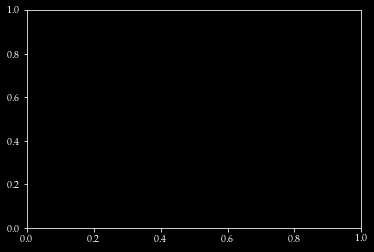

In [25]:
N = int(1e3); ts  = np.linspace(0,T,N+1); Ts  = np.array([ts]).T

J = 10000; rdm.seed(11)
X    = x0 * np.exp(sigBS * BM(Ts,J) + (r - sigBS**2/2) * Ts)
G    = g(X)




pBS,*_ = bsVanilla(x0,K,r,delta,sigBS,T)
print("BS price: %2.2f"%pBS)


xs = np.linspace(0.75*x0,1.25*x0,201) # Space grid
G  = g(xs)  # Terminal payoff
    
for sig in [0.01,0.2,0.5]:
    # FTE coefficients
    lbda = statRep(sigBa = sig * x0); GHat = gHat(X[-1],lbda)
    #plt.ylabel(r"$\hat{g}_1(X_T)$",rotation = 0)
    #plt.plot([np.min(G),np.max(G)],[np.min(G1),np.max(G1)],color = "w")
    #plt.title("Bachelier vol = %2.2f. Price = %2.2f"%(s*x0,MC(G1))); plt.show()
    
    G1 = g1(xs,lbda)
    plt.plot(xs,GHat); plt.plot(xs,G) 
    #plt.title("Bachelier vol = %2.2f"%(s*x0)); 
plt.show()

In [22]:
GHat

array([ 7.55415023, 10.20425258, 31.3942686 , ...,  9.44224665,
        8.35651737,  9.74294804])

## Final Payoff

In [5]:
# Stock Grid
xMin,xMax = 0.75*K, 1.25*K
xs        = np.linspace(xMin,xMax,1001)
# Max Bachelier volatility (normalized)
sigMin, sigMax = 0.05, 1.0

def update_Price(message):
    if message['name'] == 'value':
        sig_         = slider.value
        lbda        = statRep(sigBa = sig_ * x0)
        plot.y       = g1(xs,lbda)
        figure.title = title(sig_)

#===================== PLOT =====================# 
title = lambda sig: 'Call payoff, K = %2.f, T = %2.f, Bachelier volatility = %2.f%%'%(K,T,100*sig)

figure = bqplt.figure(title = title(sigMin),animation_duration=0,legend_location = "top-left")
bqplt.xlabel("Stock Price"); bqplt.xlabel("Payoff") 
# Call payoff
bqplt.plot(xs,g(xs[__,:]),stroke_width = 3,labels = ["Call Payoff"],
           display_legend = False,colors = ["cornflowerblue"],opacities = [0.8])
# Replication, BS vol
bqplt.plot(xs,g1(xs,statRep(sigBa = sigBS * x0)),stroke_width = 3,
           labels = ["Static Replication (BS Vol)"], display_legend = True, 
           colors = ["crimson"],opacities = [1.0])
# Replication, init vol
plot = bqplt.plot(xs,g1(xs,statRep(sigBa = sigMin * x0)),stroke_width = 3,
                  labels = ["Static Replication"],display_legend = True, colors = ["plum"],
                  axes_options={"x": {"label": "Stock Price", "num_ticks":21}})

plot.observe(update_Price, ['x','y'])
bqplt.xlim(xMin,xMax); bqplt.ylim(-K/20,xMax-K+1)
# Slider (log2 of number of time steps)
slider = wi.FloatSlider(description=r'$\sigma_{\text{Bach}}$', step=0.01, min = sigMin, max = sigMax)
slider.observe(update_Price,'value')
# Display animation
wi.VBox([slider, figure])

## Initial Price

In [6]:
# Stock Grid
xMin,xMax = 0.6*K, 1.4*K; yMin, yMax = -K/20,xMax-K+1
xs     = np.linspace(xMin,xMax,51)
# BS prices
pBS,*_ = bsVanilla(xs,K,r,delta,sigBS,T)
# Max Bachelier volatility (normalized)
sigMin, sigMax = 0.1, 0.4
# BS paths starting from 1
J = 1000
X1   = np.exp(sigBS * np.sqrt(T) * rdm.randn(1,J) + (r - sigBS**2/2) * T)

def update_Price(message):
    if message['name'] == 'value':
        sig_         = slider.value
        lbda        = statRep(sigBa = sig_ * x0)
        plot.y       = [MC(g1(x * X1,lbda)) for x in xs]
        figure.title = title(sig_)

#===================== PLOT =====================# 
title = lambda sig: 'Call Price, K = %2.f, T = %2.f, Bachelier volatility = %2.f%%'%(K,T,100*sig)

figure = bqplt.figure(title = title(sigMin),animation_duration=0,legend_location = "top-left")
bqplt.xlabel("Stock Price"); bqplt.xlabel("Payoff") 
bqplt.plot([x0,x0],[yMin,yMax],colors = ["gray"],opacities = [0.8])
# Call payoff
bqplt.plot(xs,pBS,stroke_width = 3,labels = ["Black-Scholes"],display_legend = True,colors = ["cornflowerblue"])
# Price, BS vol
lbda = statRep(sigBa = sigBS * x0)
bqplt.plot(xs,[MC(g1(x * X1,lbda)) for x in xs],stroke_width = 3,
           labels = ["Static Replication (BS Vol)"], display_legend = True, 
           colors = ["plum"],opacities = [0.8],zorders = [9])
# Price, init vol
lbda = statRep(sigBa = sigMin * x0)
plot = bqplt.plot(xs,[MC(g1(x * X1,lbda)) for x in xs],stroke_width = 3,
                  labels = ["Static Replication"],display_legend = True, colors = ["darkred"],
                  axes_options={"x": {"label": "Stock Price", "num_ticks":21}})

plot.observe(update_Price, ['x','y'])
bqplt.xlim(xMin,xMax); bqplt.ylim(yMin, yMax)
# Slider (log2 of number of time steps)
slider = wi.FloatSlider(description=r'$\sigma_{\text{Bach}}$', step=0.01, min = sigMin, max = sigMax)
slider.observe(update_Price,'value')
# Display animation
wi.VBox([slider, figure])

## Term Structure

In [8]:
# Stock Grid
TMin,TMax = 0., 0.5
Ts        = np.linspace(TMin,TMax,101); Ts_ = np.array([Ts]).T
# BS prices
pBS = [bsVanilla(x0,K,r,delta,sigBS,T_)[0] for T_ in Ts]
# Max Bachelier volatility (normalized)
sigMin, sigMax = 0.05, 0.41
# BS paths
J = int(1e5)
X    = x0 * np.exp(sigBS * np.sqrt(Ts_) * rdm.randn(len(Ts),J) + (r - sigBS**2/2) * Ts_)
  
def update_Price(message):
    if message['name'] == 'value':
        sig_           = slider.value
        lbda          = statRep(sigBa = sig_ * x0,T = Ts_)
        plot.y         = MC(g1(X,lbda,Ts_),Ts_) 
        figure.title   = title(sig_)

#===================== PLOT =====================# 
title = lambda sig: 'ATM Call Term Structure, Bachelier volatility = %2.f%%'%(100*sig)

figure = bqplt.figure(title = title(sigMin),animation_duration=0,legend_location = "top-left")
bqplt.xlabel("Stock Price"); bqplt.xlabel("Payoff") 
# BS price
bqplt.plot(Ts,pBS,stroke_width = 2,labels = ["Black-Scholes"],display_legend = True,colors = ["cornflowerblue"])
# Price, BS vol
lbda = statRep(sigBa = sigBS * x0,T = Ts_)
bqplt.plot(Ts,MC(g1(X,lbda,Ts_),Ts_),stroke_width = 2,
           labels = ["Static Replication (BS Vol)"], display_legend = True, 
           colors = ["plum"],opacities = [0.8],zorders = [9])
# "Optimal" sigma

lbda = statRep(sigBa = sigBS * x0,T = Ts_)
bqplt.plot(Ts,MC(g1(X,lbda,Ts_),Ts_),stroke_width = 2,
           labels = ["Static Replication (BS Vol)"], display_legend = True, 
           colors = ["plum"],opacities = [0.8],zorders = [9])
# Price, init vol
lbda = statRep(sigBa = sigMin * x0,T = Ts_)
plot = bqplt.plot(Ts,MC(g1(X,lbda,Ts_),Ts_),stroke_width = 2,
                  labels = ["Static Replication"],display_legend = True, colors = ["darkred"],
                  axes_options={"x": {"label": "Stock Price", "num_ticks":21}})

plot.observe(update_Price, ['x','y'])
bqplt.xlim(TMin,TMax); bqplt.ylim(0.,pBS[-1]*1.2)
# Slider (log2 of number of time steps)
slider = wi.FloatSlider(description=r'$\sigma_{\text{Bach}}$', step=0.01, min = sigMin, max = sigMax)
slider.observe(update_Price,'value')
# Display animation
wi.VBox([slider, figure])

In [229]:
g1

<function __main__.<lambda>(xT, Delta)>

In [207]:
MC(g1(X,lbda),Ts_)

array([0.        , 2.43834878, 2.62876136])

In [209]:
lbda


{'_': array([[0.        ],
        [0.9973557 ],
        [1.41047396]]),
 't': array([[ 0.        ],
        [-1.99671011],
        [-1.4111799 ]]),
 'x': array([[1.        ],
        [0.50079788],
        [0.50056419]]),
 'xx': array([[0.        ],
        [0.1595767 ],
        [0.11283784]])}

In [210]:
g1(X,lbda)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.83170175,  0.1902713 , -0.78657092,  8.80225989,  2.15408185],
       [ 7.04030495,  2.36132514,  3.58020019, -0.28797151,  0.44994801]])

In [214]:
lbda["x"] * (X-x0) + lbda["t"] * Ts_ 

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.79811161, -0.31831369, -2.09901617,  3.41928689, -5.11124421],
       [ 2.82426886, -6.43150471, -7.13337314, -2.20399486, -0.97712821]])

In [202]:
X

(51, 10000)

In [193]:
def statRep(sigBa = None,T = T,h = 0.01, dT = 0.001):  
    """Static Replication (order 1). Returns hedged values and price"""
    # Functional derivatives
    if sigBa is None: sigBa = sigBS * x0
    lbda       = {}
    lbda["_"]  = p(T,x0,K,sigBa)  # Bachelier price
    lbda["t"]  = (p(np.maximum(T-dT,0.),x0,K,sigBa) - p(T,x0,K,sigBa))/dT
    lbda["x"]  = (p(T,x0 + h,K,sigBa) - p(T,x0,K,sigBa))/h
    lbda["xx"] = (p(T,x0 + h,K,sigBa) - 2 * p(T,x0,K,sigBa) + p(T,x0 - h,K,sigBa))/h**2
    return lbda

Ts = np.linspace(TMin,TMax,5); Ts_ = np.array([Ts]).T
statRep(sigBa = sigBS * x0,T = Ts_)

{'_': array([[0.        ],
        [2.82094792],
        [3.9894228 ],
        [4.88602512],
        [5.64189584]]),
 't': array([[  0.        ],
        [-11.30644998],
        [ -7.98684045],
        [ -6.51904909],
        [ -5.64471961]]),
 'x': array([[1.        ],
        [0.50028209],
        [0.50019947],
        [0.50016287],
        [0.50014105]]),
 'xx': array([[0.        ],
        [0.05641895],
        [0.03989422],
        [0.0325735 ],
        [0.02820948]])}

In [119]:
MC(g1(X,lbda),T = Ts_)

2.632125039605402

In [112]:
X

array([[102.30382613,  98.97119933,  96.60414617],
       [110.53589391,  92.46565784,  93.84023349],
       [108.39693476, 101.60545788,  96.89701829],
       [ 94.88058912, 114.18923714, 101.61931622],
       [ 80.47183911,  97.6408856 , 107.82729746],
       [109.99473323, 105.6227037 ,  92.01318055],
       [ 85.56341287, 109.57151099, 111.80071234],
       [113.82245589,  70.79663284,  92.54964215],
       [138.11597939,  94.57814856,  89.12979796],
       [111.74478115,  67.64085786, 101.24168833],
       [ 62.86206895,  90.13011052,  84.54134818]])

In [114]:
np.exp(-r*Ts_) * g1(X,lbda)

array([[ 4.03380088,  2.30708379,  1.27094781],
       [ 9.64183076, -0.16085942,  0.26112048],
       [ 8.00085627,  3.64601062,  1.39057924],
       [ 0.61593501, 12.74309014,  3.65357209],
       [-1.58130543,  1.7053092 ,  7.58560229],
       [ 9.21446526,  6.06476372, -0.28810469],
       [-1.47398961,  8.88599493, 10.67290195],
       [12.41473338,  0.22993611, -0.13660595],
       [42.36182432,  0.50963947, -0.9632997 ],
       [10.62635356,  1.39183591,  3.44946619],
       [ 3.68611828, -0.75562734, -1.55419767]])

In [9]:
g1 = lambda xT,lbda: lbda["_"] + lbda["t"] * T \
                    + lbda["x"] * (xT - x0) + lbda["xx"] * (xT - x0)**2/2
# Stock Grid
xMin,xMax = 0., 2*K
xs     = np.linspace(xMin,xMax,1001)
# Max Bachelier volatility (normalized)
sigMax = 3.5
# Target prices
pBS = bsVanilla(xs,K,r,delta,sig,T)

def update_Price(message):
    if message['name'] == 'value':
        sig_         = slider.value
        G1,p1,lbda  = statRep(G,sigBa = sig_ * x0)
        plot.y       = g1(xs,lbda)
        figure.title = title(sig_)

#===================== PLOT =====================# 
title = lambda sig: 'Black-Scholes Price, K = %2.f, T = %2.f, volatility = %2.f%%'%(K,T,100*sig)

figure = bqplt.figure(title = title(0.),animation_duration=0,legend_location = "top-left")
bqplt.xlabel("Stock Price")

# Plot
bqplt.plot(xs,bsVanilla(xs,K,r,delta,0.,T)[:2],stroke_width = 3,
           colors = ["steelblue","purple"],opacities = [0.4],line_style = "dashed")

plot = bqplt.plot(xs,bsVanilla(xs,K,r,delta,0.,T)[:2],stroke_width = 2,
                  labels = ["Call","Put"],display_legend = True, colors = ["steelblue","purple"],
                  axes_options={"x": {"label": "Stock Price", "num_ticks":21}})

s = K*np.exp(-r*T)
bqplt.plot([s,s],[-5.,xMax+10.],stroke_width = 2,colors = ["orchid"],opacities = [0.6],line_style = "solid")
bqplt.plot([K,K],[-5.,xMax+10.],stroke_width = 2,colors = ["gray"],opacities = [0.8],line_style = "solid")

plot.observe(update_Price, ['x','y'])
bqplt.xlim(xMin,xMax); bqplt.ylim(0.,xMax)# - K)
# Slider (log2 of number of time steps)
slider = wi.FloatSlider(description=r'$\sigma$', step=0.01, min = 0, max = sigMax)
slider.observe(update_Price,'value')
# Display animation
wi.VBox([slider, figure])

NameError: name 'sig' is not defined